In [11]:
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import Callback
from keras.datasets import mnist

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Utils

In [2]:
def plotHistory(loss, acc):
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 2, 1)

    plt.plot(loss)
    plt.title('loss through training')
    plt.ylabel('loss')
    plt.xlabel('batch')

    plt.subplot(1, 2, 2)
    plt.plot(acc, 'g')
    plt.title('accuracy through training')
    plt.ylabel('accuracy')
    plt.xlabel('batch')

# Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = x_train.astype('float16') / 255.
x_test = x_test.astype('float16') / 255.

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print("training data: {}".format(x_train.shape))
print("testing data: {}".format(x_test.shape))

training data: (60000, 28, 28, 1)
testing data: (10000, 28, 28, 1)


# Network

In [13]:
encoder = Sequential([
    Convolution2D(8, kernel_size=3, padding="same", input_shape=(28, 28, 1,)),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Dropout(0.2),
    
    Convolution2D(4, kernel_size=3, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Convolution2D(4, kernel_size=3, padding="same", activation="relu"),
])

decoder = Sequential([
    UpSampling2D(size=2, input_shape=(7, 7, 4)),
    Convolution2D(8, kernel_size=3, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    
    UpSampling2D(size=2),
    Convolution2D(1, kernel_size=3, padding="same"),
    BatchNormalization(),
    Activation("relu"),
])

autoencoder = Sequential([
    encoder,
    decoder
])

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 7, 7, 4)           568       
_________________________________________________________________
sequential_5 (Sequential)    (None, 28, 28, 1)         405       
Total params: 973
Trainable params: 931
Non-trainable params: 42
_________________________________________________________________


# Hyper Parameters

In [14]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9)
autoencoder.compile(loss='mean_squared_error',
              optimizer=sgd,
              metrics=['accuracy'])

encoder.compile(loss='binary_crossentropy',
                optimizer="SGD",
                metrics=['accuracy'])

decoder.compile(loss='binary_crossentropy',
                optimizer="SGD",
                metrics=['accuracy'])

# Training

In [15]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.acc = []

    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))

In [ ]:
history = LossHistory()
autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=5, batch_size=128, callbacks=[history])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 48s - loss: 0.0552 - acc: 0.8009 - val_loss: 0.2352 - val_acc: 0.6848
Epoch 2/5
60000/60000 [==============================] - 48s - loss: 0.0273 - acc: 0.8073 - val_loss: 0.2577 - val_acc: 0.7037
Epoch 3/5
60000/60000 [==============================] - 48s - loss: 0.0236 - acc: 0.8088 - val_loss: 0.2060 - val_acc: 0.7244
Epoch 4/5
47104/60000 [======================>.......] - ETA: 9s - loss: 0.0216 - acc: 0.8097

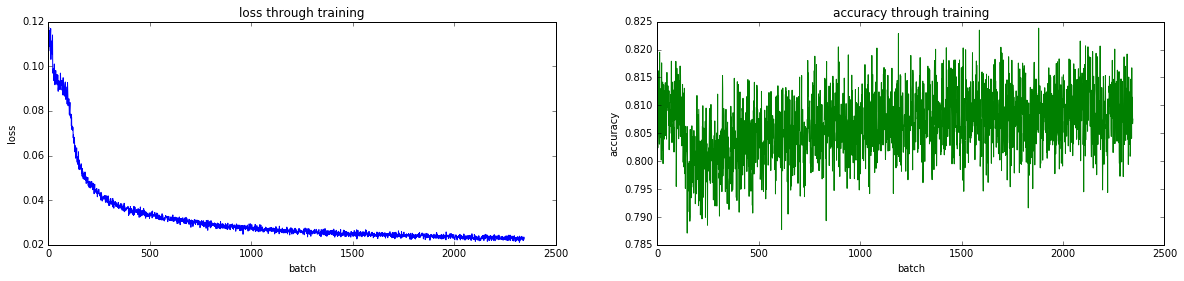

In [8]:
plotHistory(history.loss, history.acc)

# Test

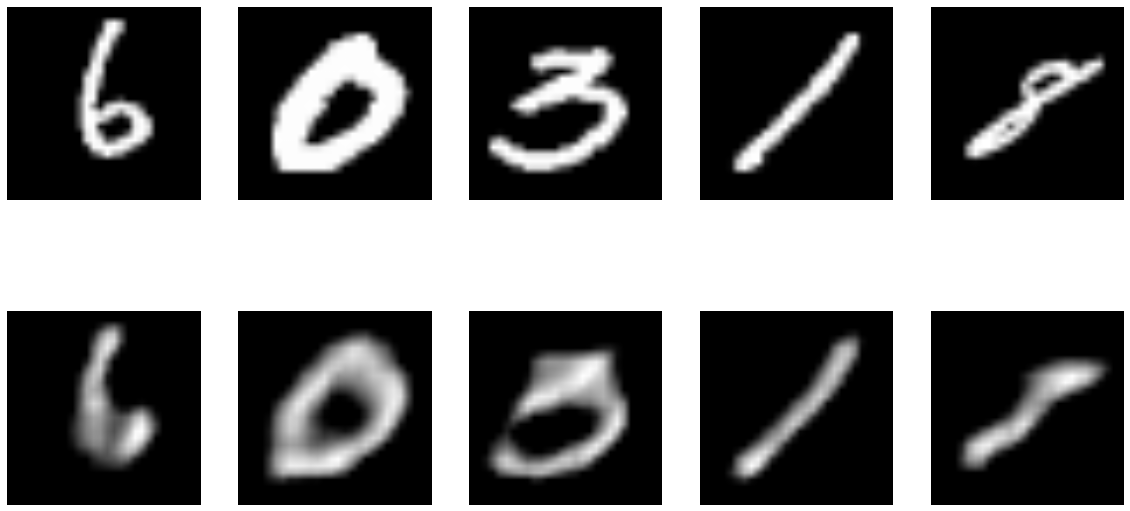

In [9]:
n_image = 5

display_index = np.random.choice(x_test.shape[0], n_image)
images = np.array([x_train[i] for i in display_index])
netout = autoencoder.predict(images)

plt.figure(figsize=(20, 10))

for i in range(n_image):
    ax = plt.subplot(2, n_image, i + 1)
    plt.imshow(images[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n_image, n_image + i + 1)
    plt.imshow(netout[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)